# Clasificación Binaria

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

La clasificación binaria es, posiblemente, el tipo de problema con mayor número de aplicaciones en ML. En este vamos a ver cómo construir un clasificador en Keras. Concretamente, construiremos una red neuronal que nos ayude a clasificar opiniones de películas como "positivas/negativas" únicamente basándonos en el contenido textual de las mismas. Será un ejemplo de lo que se conoce actualmente como **Análisis de Sentimientos**.

## El Dataset IMDB

Usaremos uno de los datasets que proporciona el sitio [IMDB](https://www.imdb.com) (Internet Movie DataBase) formado por 50,000 opiniones altamente polarizadas (lo que simplifica la tarea de aprendizaje). Este conjunto está dividido en 50%/50% para entrenamiento/test, y en cada uno de ellos hay un 50% de opiniones de cada tipo.

AL igual que con el dataset anterior (MNIST) este dataset también viene con Keras, y además se proporciona preprocesado: por medio de un diccionario indexado, las opiniones (secuencias de palabras) se han convertido en secuencias de enteros.

El código que carga el dataset (unos 80Mb de datos que serán descargados la primera vez que se ejecuta) es:

In [2]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)


Como el diccionario es tremendamente grande y hay muchas palabras que se usan rara vez, nos quedaremos solo con las 10,000 palabras más frecuentes (algo que conseguimos por medio del argumento `num_words = 10000` en el proceso de carga). 

Si quieres, puedes explorar el contenido de las variables `train_data` y `test_data`, que son listas de opiniones, donde cada opinión es una lista de enteros (codificando una secuencia de palabras). Las variables `train_labels` y `test_labels` son listas binarias, donde 0 indica que la opinión asociada es _negativa_ y 1 que es _positiva_:

In [3]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [4]:
train_labels[0]

1

Puedes observar que los índices de las palabras almacenadas están por debajo de 10,000:

In [5]:
max([max(sequence) for sequence in train_data])

9999

Aunque no es necesario para el entrenamiento posterior, podemos construir funciones que reconstruyen las opiniones a partir de las secuencias de índices:

In [6]:
# word_index is a dictionary mapping words to an integer index
word_index = imdb.get_word_index()
# We reverse it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [7]:
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

## Preparación de los datos

Como las redes neuronales no admiten listas de enteros como entrada, porque son de longitud variable, hemos de añadir un preprocesado adicional para poder trabajar con ellas. Tenemos dos opciones:

* Completar las listas más cortas para que todas tengan la misma longitud y, entonces, convertirlas en tensores que alimentarán la capa de entrada de la red.
* Codificar en One-hot las listas para convertirlas en vectores de 0s y 1s. Como tenemos un máximo de 10,000 palabras en nuestro vocabulario, cada opinión se convertirá en una lista binaria de 10,000 posiciones indicando qué palabras aparecen en la opinión. En este caso, la primera capa (densa) de nuestra red se conectaría con vectores de longitud 10,000.

Optaremos por esta segunda opción, que con el tiempo veremos que tiene más ventajas que la primera. 

El código que permite hacer esta conversión es:

In [8]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

Este es el nuevo aspecto que tendría una opinión:

In [9]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

También tendríamos que hacer una conversión con las etiquetas, pero como en este caso ya son vectores binarios, basta convertirlos en numéricos:

In [10]:
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

## Definiendo la Red

Como hemos visto, los datos de entrada son vectores, y las etiquetas son escalares (1s y 0s), así que estamos ante la configuración más sencilla de las posibles para ser trabajadas con una red neuronal, y un tipo de red que funciona bien con este tipo de problemas es una simple pila de capas densas con activaciones `relu`, que en Keras se construyen con la instrucción: `layers.Dense(16, activation='relu')`.

En general, en todo tipo de capas, los argumentos más habituales que tendrás que usar serán el número de neuronas en la capa, y el tipo de activación que usarán estas neuronas. En el caso anterior usamos 16 neuronas, lo que significa que esta capa usará 16 dimensiones para intentar estructurar los patrones que encuentre en los datos de entrada según la función objetivo (loss) que deba optimizar. 

Se puede interpretar intuitivamente que la dimensión de la capa representa cuánta libertad se permite a la red para aprender representaciones internas. Tener más unidades permite aprender representaciones más complejas, pero también aumenta la carga computacional y facilita la memorización de patrones en los datos de entrenamiento (que quizás no sean relevantes para el problema y que puede llevar a un fenómeno de sobreajuste).

Respecto a la arquitectura al trabajar con capas densas, hay dos decisiones claves que considerar:

* Cuántas capas usar.
* Cuántas unidades colocar en cada capa.

Aunque no hay reglas generales para saber cómo tomar estas decisiones, sí que hay algunas razones que se pueden aprender con la experiencia y así poder extraer algún conocimiento implícito útil para el diseño de redes. Para este ejemplo, sin una justificación clara, y solo a modo de demostración de las técnicas vamos a usar dos capas intermedias de 16 neuronas cada una, y una tercera capa que tendrá una única salida escalar (que representará la predicción del modelo). Las capas inermedias usarán `relu` como función de activación, y la capa final usará una sigmoide (que tiene una salida en $[0, 1]$).

La implementación en Keras, similar a la que ya hicimos para MNIST, es por tanto:

In [12]:
from keras import models
from keras import layers
from keras.utils.vis_utils import plot_model

red = models.Sequential()
red.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
red.add(layers.Dense(16, activation='relu'))
red.add(layers.Dense(1, activation='sigmoid'))

![](./imgs/IMDBModel_plot.png)

Siguiendo el mismo patrón que vimos en el ejemplo anterior, necesitamos elegir la función de pérdida (que será minimizada) y el método de optimización (que será el que busque minimizar esa función). 

Como estamos ante un problema de clasificación binaria y la salida de nuestra red es una probabilidad (proporcionada por la sigmoide), usaremos `binary_crossentropy` como función de pérdida. No es la única opción viable, podríamos haber elegido, por ejemplo, `mean_squared_error`, pero en este caso `binary_crossentropy` es una mejor opción por estar trabajando con probabilidades. La entropía cruzada proviene del campo de **Teoría de la Información**, y mide la distancia entre distribuciones de probabilidad (en este caso, la distribución calculada por el predictor y la que representa la distribución _real_ proveniente de los datos de entrenamiento).

Como optimizador usaremos `rmsprop`, que suele ser una buena elección en casi todos los casos. Para monitorear la evolución del aprendizaje usaremos una sola métrica, _accuracy_.

In [13]:
red.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

En este caso estamos pasando todos los datos como cadenas que vienen predefinidas en Keras y trabajan con parámetros fijos, pero también es posible ajustar con más flexibilidad cada una de ellas y configurar los parámetros de los que depende, e incluso pasarle funciones, ya sean las que trae Keras o completamente personalizadas. Por ejemplo:

In [14]:
from keras import optimizers

red.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

O incluso de forma más detallada como:

In [15]:
from keras import losses
from keras import metrics

red.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

## Validando el modelo

Con el fin de monitorizar la métrica (_accuracy_) mientras se produce el entrenamiento necesitamos tener más datos que el modelo no use durante el proceso. Crearemos para ello un *conjunto de validación* separando otras 10,000 muestras del conjunto original. Así pues la situación queda como:

* _Conjunto de entrenamiento_: con el que intentaremos optimizar los pesos de la red para que minimice la función de pérdida. En este proceso se usa un modelo que depende de ciertos parámetros que quizás deban ser ajustados para conseguir mejorar el rendimiento.

* _Conjunto de validación_: con el que se medirá cómo de bueno es el modelo concreto que estamos entrenando (con unos parámetros fijos). Es algo así como un conjunto de test temporal. Permite ajustar estos parámetros para mejorar el rendimiento.

* _Conjunto de test_: que no se ha usado en ningún momento de las iteraciones anteriores y que permite medir de forma objetiva la bondad del modelo final obtenido.

In [16]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

A continuación, entrenaremos el modelo realizando 20 iteraciones (_epochs_) sobre el conjunto completo de entrenamiento, ni validación, ni test), en mini-batches de 512 muestras (es decir, cada 512 muestras analizadas, se actualizan los pesos de la red). Monitorearemos _loss_ y _accuracy_ sobre las 10,000 muestras que dejamos en el conjunto de validación. Para ello, usamos el argumento `validation_data` de la función `fit`, que no usamos en el ejemplo anterior:

In [17]:
entrenamiento = red.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 8s 506us/step - loss: 0.5376 - binary_accuracy: 0.7751 - val_loss: 0.4022 - val_binary_accuracy: 0.8672
Epoch 2/20
15000/15000 [==============================] - 5s 321us/step - loss: 0.3226 - binary_accuracy: 0.8979 - val_loss: 0.3276 - val_binary_accuracy: 0.8721
Epoch 3/20
15000/15000 [==============================] - 4s 270us/step - loss: 0.2359 - binary_accuracy: 0.9239 - val_loss: 0.2857 - val_binary_accuracy: 0.8872
Epoch 4/20
15000/15000 [==============================] - 4s 267us/step - loss: 0.1852 - binary_accuracy: 0.9396 - val_loss: 0.2740 - val_binary_accuracy: 0.8907
Epoch 5/20
15000/15000 [==============================] - 4s 278us/step - loss: 0.1537 - binary_accuracy: 0.9503 - val_loss: 0.2992 - val_binary_accuracy: 0.8816
Epoch 6/20
15000/15000 [==============================] - 4s 281us/step - loss: 0.1246 - binary_accuracy: 0.9605 - val_loss: 0.2873 - val_bi

Aunque no lo usamos en el ejemplo anterior, y tampoco pasamos el resultado a una variable para poder hacerlo, la llamada a `fit()` devuelve un objeto `history`, que tiene la siguiente estructura:


In [18]:
entrenamiento_dict = entrenamiento.history
entrenamiento_dict.keys()

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])

En este caso, este objeto contiene 4 entradas, una por cada métrica que está siendo monitorizada durante el entrenamiento y durante la validación. Podemos usar `Matplotlib` para representar las pérdidas/precisión de entrenamiento y validación simultáneamente:

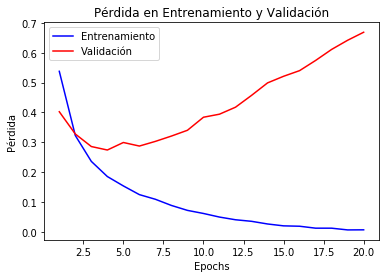

In [20]:
import matplotlib.pyplot as plt

ent_acc = entrenamiento.history['binary_accuracy']
val_acc = entrenamiento.history['val_binary_accuracy']
ent_loss = entrenamiento.history['loss']
val_loss = entrenamiento.history['val_loss']

epochs = range(1, len(ent_acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, ent_loss, 'b', label='Entrenamiento')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'r', label='Validación')
plt.title('Pérdida en Entrenamiento y Validación')
plt.xlabel('Epochs')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

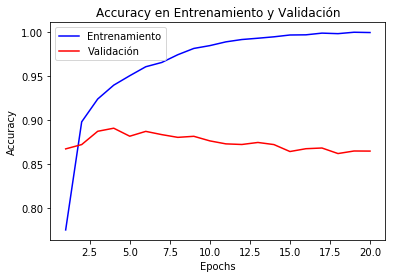

In [21]:
plt.clf()   # clear figure
acc_values = entrenamiento_dict['binary_accuracy']
val_acc_values = entrenamiento_dict['val_binary_accuracy']

plt.plot(epochs, ent_acc, 'b', label='Entrenamiento')
plt.plot(epochs, val_acc, 'r', label='Validación')
plt.title('Accuracy en Entrenamiento y Validación')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Estas gráficas muestras que la _pérdida_ de entrenamiento decrece en cada epoch, y que el _accuracy_ en entrenamiento crece, algo que indica que el procedimiento de optimización está funcionando adecuadamente (sobre todo respecto a la función de pérdida). Pero en este caso observamos que no ocurre lo mismo con la validación, que empiezan a empeorar a partir de la epoch 4. Estamos ante un claro caso de *overfitting*: tras unos pocos pasos el sistema se sobreajusta a los datos de entrenamiento, y aprende una representación que es específica a estos datos y que no puede generalizarse a otros datos.

En este caso, para prevenir el overfitting podríamos parar el entrenamiento tras las 3 primeras iteraciones. Más adelante veremos algunas otras técnicas para mitigar este efecto, pero por ahora nos contentaremos con este procedimiento que, aún lejos de ser el mejor, evita este problema ahora mismo.

Vamos a entrenar una nueva red desde el principio pero solo durante 4 epochs y después evaluaremos el modelo sobre los datos de test (observa que estos datos no los hemos usado en ningún momento hasta ahora):

In [22]:
red2 = models.Sequential()
red2.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
red2.add(layers.Dense(16, activation='relu'))
red2.add(layers.Dense(1, activation='sigmoid'))

red2.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

entrenamiento = red2.fit(x_train, y_train, epochs=4, batch_size=512, validation_data=(x_val, y_val))
results = red2.evaluate(x_test, y_test)

Train on 25000 samples, validate on 10000 samples
Epoch 1/4
25000/25000 [==============================] - 6s 248us/step - loss: 0.4749 - acc: 0.8216 - val_loss: 0.3028 - val_acc: 0.9092
Epoch 2/4
25000/25000 [==============================] - 6s 229us/step - loss: 0.2666 - acc: 0.9096 - val_loss: 0.2006 - val_acc: 0.9335
Epoch 3/4
25000/25000 [==============================] - 6s 223us/step - loss: 0.1986 - acc: 0.9293 - val_loss: 0.1631 - val_acc: 0.9441
Epoch 4/4
25000/25000 [==============================] - 12s 490us/step


{'val_loss': [0.30281208176612856, 0.2006478396177292, 0.1631037590265274, 0.14689231829643248], 'val_acc': [0.909200000667572, 0.9334999998092651, 0.9440999999046326, 0.95], 'loss': [0.4749279691696167, 0.2665864489173889, 0.19855074528217315, 0.16787961939811707], 'acc': [0.8216000003814697, 0.9095600003814698, 0.9292799998855591, 0.9403600002288819]}


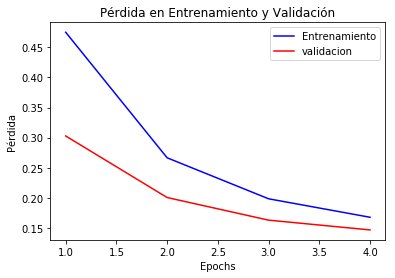

In [26]:
import matplotlib.pyplot as plt
print(entrenamiento.history)

ent_loss = entrenamiento.history['loss']
val_loss = entrenamiento.history['val_loss']
epochs = range(1, len(ent_loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, ent_loss, 'b', label='Entrenamiento')
plt.plot(epochs, val_loss, 'r', label='validacion')
# b is for "solid blue line"
plt.title('Pérdida en Entrenamiento y Validación')
plt.xlabel('Epochs')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

In [20]:
results

[0.3231546004009247, 0.87348]

Vemos que la aproximación tan simple que hemos hecho consigue un accuracy del 88% (el estado del arte actual para este problema ronda del 95%, pero trabajando sobre redes mucho más elaboradas).

## Predicciones sobre datos nuevos

Tras haber entrenado la red, el paso natural es usar el modelo para algo práctico. Puedes generar nuevas predicciones sobre opiniones para analizar si son positivas o no usando  el método `predict` asociado al modelo:

In [21]:
red2.predict(x_test)

array([[0.14026152],
       [0.9997029 ],
       [0.2955257 ],
       ...,
       [0.0723498 ],
       [0.04342838],
       [0.4815339 ]], dtype=float32)

Verás que el modelo es muy determinante en algunos casos (alcanzando valores como 0.99 o 0.01) pero no tanto en otros (como 0.46).

## Trabajo Propuesto

* En los modelos anteriores hemos usado 2 capas ocultas... comprueba el efecto de ampliar o reducir este número sobre la accuracy de validación y de test.
* Cambia el número de unidades en las capas ocultas (8, 32, 64,...) y mide su efecto.
* Mira qué ocurre al usar `mse` como función de pérdida, en vez de `binary_crossentropy`.
* Mira qué ocurre al usar la activación `tanh` en vez de `relu`.